# Fake news classifier using different algorithms
- <b>trainning on : title and author</b>
- tfidf vectorizer and gri _searchCV
1. MultinomialNB(vanilla and with tuning)
2. PassiveAggressiveClassifier(vanilla and with tuning)
3. LogisticRegression
*source: https://www.kaggle.com/c/fake-news/data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
### importing and loading

In [4]:
#import os
#import sys
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

import re 
from nltk.corpus import stopwords 

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.model_selection import train_test_split 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [5]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/firstOne/train.csv')
df= df.drop(columns='id', axis=1) # id column is not necessary
display(df.head(3))

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


##### Note: 1 means Fake news,0 means not Fake news

### Data Analysis

In [6]:
print('shape', df.shape)
print(df.info())

shape (20800, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.1+ KB
None


In [7]:
# null value check
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
# missing = df.title.mean( )
# data = df.dropna(subset=['title'])
# print(data)
# data = data[data['title'].notnull()]
# print(data)
data =df.dropna(axis=0, subset=('title', ))
print(data)

## making new data frame with dropped NA values
# new_data = df.dropna(axis = 0, how ='title')
  
# # comparing sizes of data frames
# print("Old data frame length:", len(data), "\nNew data frame length:", 
#        len(new_data), "\nNumber of rows with at least 1 NA value: ",
#        (len(data)-len(new_data)))

                                                   title  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...   
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                      Why the Truth Might Get You Fired   
3      15 Civilians Killed In Single US Airstrike Hav...   
4      Iranian woman jailed for fictional unpublished...   
...                                                  ...   
20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiumnews.com   
3                                Jessica Purkiss   
4                  

In [9]:
# Replacing the null values with emtpy strings 
df = df.fillna('')
df.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

### Text preprocessing- on 'author' and 'title' column


In [10]:
#merging the author name and news title and make a new column
df['content'] = df['author']+' '+df['title']
df['content']

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object

### Now we will separate the data and label

In [11]:
#X = df.drop(columns='label', axis=1)
# X=df['content']
X=df['content']
Y = df['label']
display(X.head())
print(Y.head())

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: content, dtype: object

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64


#### Stemming and other preprocessing

In [12]:
#take 5000 rows from df
#df=df[:1000]
#df.head()
df.shape
#df['text']

(20800, 5)

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# stemming 
ps = PorterStemmer()
# corpus = []
# for i in range(0, len(df)):
#     review = re.sub('[^a-zA-Z]', ' ', df['content'][i]) # only the content column
#     review = review.lower()
#     review = review.split()
    
#     review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
#     review = ' '.join(review)
#     corpus.append(review)

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content
    
    
df['content'] = df['content'].apply(stemming)

In [15]:
# df['content'][:5]
df['content'][:20]
#df.head()

0     darrel lucu hous dem aid even see comey letter...
1     daniel j flynn flynn hillari clinton big woman...
2                consortiumnew com truth might get fire
3     jessica purkiss civilian kill singl us airstri...
4     howard portnoy iranian woman jail fiction unpu...
5     daniel nussbaum jacki mason hollywood would lo...
6     life life luxuri elton john favorit shark pict...
7     alissa j rubin beno hamon win french socialist...
8     excerpt draft script donald trump q ampa black...
9     megan twohey scott shane back channel plan ukr...
10    aaron klein obama organ action partner soro li...
11    chri tomlinson bbc comedi sketch real housew i...
12    amando flavio russian research discov secret n...
13           jason ditz us offici see link trump russia
14    anotheranni ye paid govern troll social media ...
15    jack william major leagu soccer argentin find ...
16    michael corkeri staci cowley well fargo chief ...
17    starkman anonym donor pay million releas e

In [16]:
# Separating data and label
X = df['content'].values
y = df['label'].values
X
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


#### TfidfVectorizer

In [17]:
 # i want to take 5000 feayures and (1,3) means features will be single,double or triple word
tf= TfidfVectorizer(max_features=5000,ngram_range=(1,3)) 
X=tf.fit_transform(df['content']).toarray()
print(X.shape)
print(X)

(20800, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### check features

In [18]:
tf.get_feature_names()[:10] # first 10 features

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaron',
 'aaron carrol',
 'aaron kesel',
 'aaron klein',
 'aaron klein ali',
 'abandon',
 'abbi',
 'abbi goodnough',
 'abc',
 'abduct']

In [19]:
tf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [20]:
verctor = TfidfVectorizer(stop_words='english', max_df=0.7)

In [21]:
# #fit and transform
# tf_train = vector.fit_transform(X_train)
# tf_test = vector.transform(X_test)

### Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [23]:
# X_train.head()

In [24]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [25]:
count_df = pd.DataFrame(X, columns=tf.get_feature_names())
count_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,aaron carrol,aaron kesel,aaron klein,aaron klein ali,abandon,abbi,abbi goodnough,abc,abduct,...,zika,zika viru,zionist,zone,zraick,zraick sandra,zraick sandra stevenson,zu,zuckerberg,zuess
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# X_train, X_test, y_train, y_test = train_test_split(df['content'], y, test_size=0.20, random_state=42)

### Algorithms

#### 1. Multinomial NB

MNB accuracy_score 0.9632211538461538


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


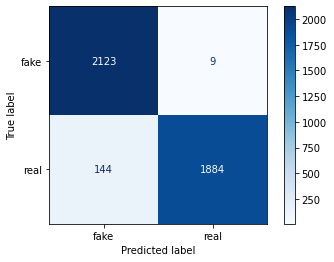

In [27]:
clf=MultinomialNB()
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
MNB_accuracy=metrics.accuracy_score(y_test,pred)
print('MNB accuracy_score',MNB_accuracy)

plot_confusion_matrix(clf,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()

#### 1.1 multinomialNB with hyperparameter

In [28]:
alpha=[0.01, 0.1, 0.5, 1.0, 10.0, ]
parameters={'alpha': alpha }

clf_gs=MultinomialNB()

gscv=GridSearchCV(estimator=clf_gs,
                 param_grid=parameters,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)

gscv=gscv.fit(X_train,y_train)
gscv
         

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='accuracy')

In [29]:
gscv.best_params_

{'alpha': 1.0}

Accuracy_tuning 0.9632211538461538


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


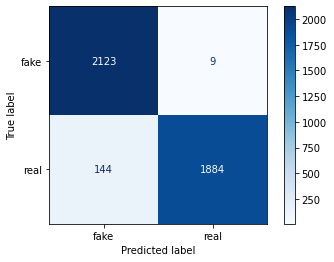

In [30]:
y_pred_gs =gscv.predict(X_test) 
MNB_t_accuracy=metrics.accuracy_score(y_test,y_pred_gs)
print('Accuracy_tuning',MNB_t_accuracy)

plot_confusion_matrix(gscv,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()


#### 2. passive aggresive classifier algorithm

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Passive_agg_accuracy_score 0.9932692307692308


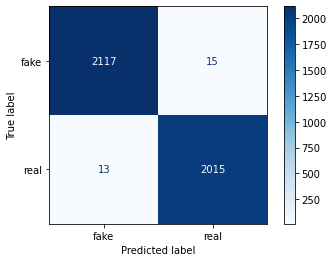

In [31]:
clf = PassiveAggressiveClassifier(max_iter=10,random_state=42)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
pass_agg=metrics.accuracy_score(y_test,pred)
print('Passive_agg_accuracy_score',pass_agg)

plot_confusion_matrix(clf,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()

#### 2.1 with tuning

In [32]:
max_iter=[50,100,200]
shuffle=[True]
random_state=[42]

parameters={'max_iter': max_iter,
           'shuffle':shuffle,
           'random_state':random_state}

clf_gs=PassiveAggressiveClassifier()

gscv=GridSearchCV(estimator=clf_gs,
                 param_grid=parameters,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)

gscv2=gscv.fit(X_train,y_train)
gscv2
         

GridSearchCV(cv=5, estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'max_iter': [50, 100, 200], 'random_state': [42],
                         'shuffle': [True]},
             scoring='accuracy')

In [33]:
gscv2.best_params_

{'max_iter': 50, 'random_state': 42, 'shuffle': True}

Accuracy_with_tuning 0.9932692307692308


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


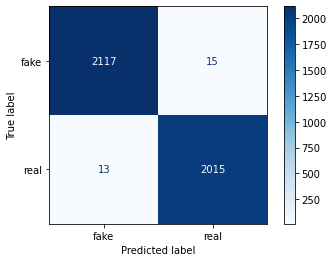

In [34]:
y_pred_gs =gscv2.predict(X_test) 
pass_agg_t=metrics.accuracy_score(y_test,y_pred_gs)
print('Accuracy_with_tuning',pass_agg_t)

plot_confusion_matrix(gscv,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()


#### 3. Logistic regression algorithm

logistic reg. accuracy_score 0.9836538461538461


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


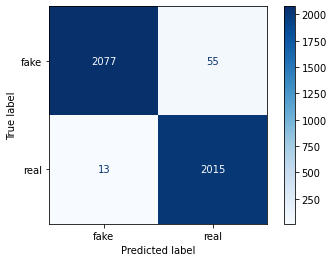

In [35]:
clf_log= LogisticRegression()

clf_log.fit(X_train,y_train)
pred=clf_log.predict(X_test)
log_r_accuracy=metrics.accuracy_score(y_test,pred)
print('logistic reg. accuracy_score',log_r_accuracy)

plot_confusion_matrix(clf_log,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()

In [36]:
# Support Vector Classification :

# from sklearn import svm
# SvcModel=svm.SVC( )
# SvcModel.fit(X_train,y_train)
# pred=SvcModel.predict(X_test)
# SVCmodel=metrics.accuracy_score(y_test,pred)
# print('SVCmodel accuracy_score: ',SVCmodel)


RandomForestClassifier:

In [37]:
from sklearn.ensemble import RandomForestClassifier
Rfcl = RandomForestClassifier()
Rfcl.fit(X_train,y_train)

RandomForestClassifier()

In [38]:
pred1=Rfcl.predict(X_test)
RFCLmodel = metrics.accuracy_score(y_test,pred1)
print('RFCLmodel accuracy_score: ',RFCLmodel)

RFCLmodel accuracy_score:  0.9930288461538461


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


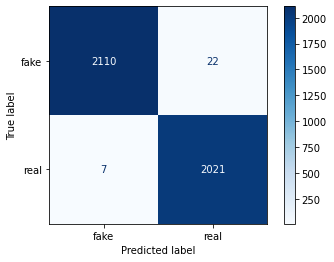

In [39]:
plot_confusion_matrix(Rfcl,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()

5 . DecisionTreeClassifier:

In [40]:

from sklearn.tree import DecisionTreeClassifier
Dtc=DecisionTreeClassifier( )
Dtc.fit(X_train,y_train)
pred=Dtc.predict(X_test)
DTCmodel = metrics.accuracy_score(y_test,pred)
print('DTCmodel accuracy_score: ',DTCmodel)

DTCmodel accuracy_score:  0.9913461538461539


 6 . K-Nearest Neighbors Algorithm :

In [41]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
pred_KNN=classifier.predict(X_test)
KNNmodel = metrics.accuracy_score(y_test,pred_KNN)
print('KNNmodel accuracy_score: ',KNNmodel)

KNNmodel accuracy_score:  0.6257211538461539


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


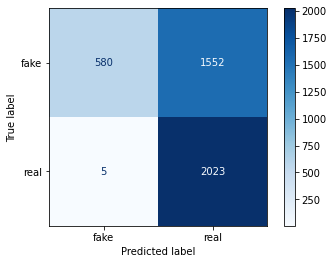

In [42]:
plot_confusion_matrix(classifier,X_test,y_test,display_labels=['fake','real'],cmap='Blues')
plt.show()

### comparioson

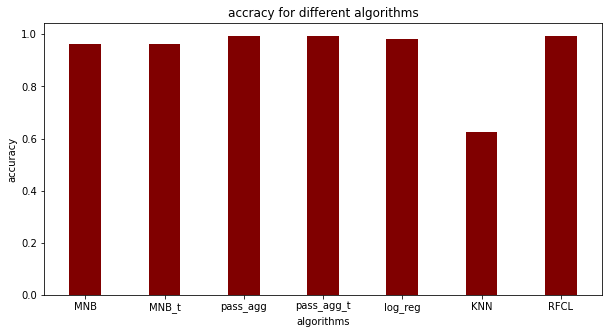

MNB_accuracy 0.9632211538461538
MNB_t_accuracy 0.9632211538461538
pass_agg_accuracy 0.9932692307692308
pass_agg_t 0.9932692307692308
log_reg 0.9836538461538461
KNN 0.6257211538461539
RFCL 0.9930288461538461


In [43]:
# import matplotlib.pyplot as plt
 
  
# # creating the dataset
# data = {'MNB':MNB_accuracy, 'MNB_t':MNB_t_accuracy, 'pass_agg':pass_agg,
#         'pass_agg_t':pass_agg_t,'log_reg':log_r_accuracy}
# algos = list(data.keys())
# accuracy = list(data.values())
  
# fig = plt.figure(figsize = (10, 5))
 
# # creating the bar plot
# plt.bar(algos, accuracy, color ='maroon',
#         width = 0.4)
 
# plt.xlabel("algorithms")
# plt.ylabel("accuracy")
# plt.title("accracy for different algorithms")
# plt.show()
 
    
# print('MNB_accuracy',MNB_accuracy)
# print('MNB_t_accuracy',MNB_t_accuracy)
# print('pass_agg_accuracy',pass_agg)
# print('pass_agg_t',pass_agg_t)
# print('log_reg',log_r_accuracy)



import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'MNB':MNB_accuracy, 'MNB_t':MNB_t_accuracy, 'pass_agg':pass_agg,
        'pass_agg_t':pass_agg_t,'log_reg':log_r_accuracy,'KNN':KNNmodel,'RFCL':RFCLmodel}
algos = list(data.keys())
accuracy = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(algos, accuracy, color ='maroon',
        width = 0.4)
 
plt.xlabel("algorithms")
plt.ylabel("accuracy")
plt.title("accracy for different algorithms")
plt.show()
 
    
print('MNB_accuracy',MNB_accuracy)
print('MNB_t_accuracy',MNB_t_accuracy)
print('pass_agg_accuracy',pass_agg)
print('pass_agg_t',pass_agg_t)
print('log_reg',log_r_accuracy)
print('KNN',KNNmodel)
print('RFCL',RFCLmodel)

#### Note: passive aggrassive algorithm works best

In [44]:
X_new = X_test[[100]]

prediction = clf.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('The news in Real')
else:
  print('The news is Fake and Unreliable')

[1]
The news is Fake and Unreliable


In [45]:
#save model
import pickle 
filename= 'finalized_model.pkl'
pickle.dump(clf, open(filename,  'wb'))

In [46]:
# save vectorizer
import pickle
filename = 'vectorizer.pkl'
pickle.dump(tf, open(filename,'wb'))